# K-Nearest Neighbors - Open-world Binary Scenario (Extra Features)

**Feature 소스**: extra_credit/features/extra_mon_features.pkl, extra_unmon_features.pkl
- **시나리오**: Monitored vs Unmonitored 이진 분류
- **Extra Features 사용**: 모든 17개 extra features 사용


## 1. 라이브러리 및 데이터 로드


In [1]:
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("라이브러리 로드 완료")


라이브러리 로드 완료


In [2]:
# Load extra features (numpy 2.x 호환 패치)
print("Extra Monitored 데이터 로드 중...")

# numpy 2.x 환경에서 예전 버전으로 저장된 pickle 호환을 위한 패치
import sys
import numpy.core.numeric as _numeric
sys.modules.setdefault('numpy._core.numeric', _numeric)

# Monitored: extra features
mon_features = pd.read_pickle('../../features/extra_mon_features.pkl')
print(f"Monitored 데이터 형태: {mon_features.shape}")

# Unmonitored: extra features
print("\nExtra Unmonitored 데이터 로드 중...")
unmon_features = pd.read_pickle('../../features/extra_unmon_features.pkl')
print(f"Extra Unmonitored 데이터 형태: {unmon_features.shape}")
print("데이터 로드 완료!")


Extra Monitored 데이터 로드 중...
Monitored 데이터 형태: (19000, 18)

Extra Unmonitored 데이터 로드 중...
Extra Unmonitored 데이터 형태: (19000, 18)
데이터 로드 완료!


## 2. Feature 선택


In [3]:
# 모든 extra features 사용 (label 제외)
feature_cols = [col for col in mon_features.columns if col != 'label']
selected_features = feature_cols

print(f"선택된 Feature 수: {len(selected_features)}")
print("\nFeature 목록:")
for i, feature in enumerate(selected_features, 1):
    print(f"{i:2d}. {feature}")


선택된 Feature 수: 17

Feature 목록:
 1. total_transmission_time
 2. std_inter_packet_time
 3. avg_outgoing_burst_size
 4. avg_incoming_burst_size
 5. num_outgoing_packets
 6. incoming_packet_ratio
 7. outgoing_packet_ratio
 8. cumul_packets_10pct
 9. cumul_packets_30pct
10. outgoing_order_skew
11. incoming_order_skew
12. cumul_max
13. bigram_OO
14. num_incoming_first_30
15. outgoing_first_30
16. avg_incoming_order_first_30
17. avg_outgoing_order_first_30


## 3. 데이터 준비 (Binary Classification)


In [4]:
# Open-world binary: monitored vs unmonitored 이진 분류
# Combine mon_features and unmon_features
features_df = pd.concat([mon_features, unmon_features], ignore_index=True)

# Create binary labels: 1 for monitored, 0 for unmonitored
y = (features_df['label'] >= 0).astype(int)  # Monitored (0-94) -> 1, Unmonitored (-1) -> 0

X = features_df[selected_features]

print(f"전체 샘플 수: {X.shape[0]}")
print(f"Feature 수: {X.shape[1]}")
print(f"Monitored 샘플: {sum(y == 1)} (클래스 1)")
print(f"Unmonitored 샘플: {sum(y == 0)} (클래스 0)")
print(f"클래스 비율: {sum(y == 1)/sum(y == 0):.1f}:1")

# 데이터 분할 (80% 훈련, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n훈련 데이터: {X_train.shape[0]} 샘플")
print(f"  - Monitored: {sum(y_train == 1)} 샘플")
print(f"  - Unmonitored: {sum(y_train == 0)} 샘플")
print(f"테스트 데이터: {X_test.shape[0]} 샘플")
print(f"  - Monitored: {sum(y_test == 1)} 샘플")
print(f"  - Unmonitored: {sum(y_test == 0)} 샘플")

# KNN은 거리 기반이므로 스케일링 필요
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("\n데이터 스케일링 완료!")


전체 샘플 수: 38000
Feature 수: 17
Monitored 샘플: 19000 (클래스 1)
Unmonitored 샘플: 19000 (클래스 0)
클래스 비율: 1.0:1

훈련 데이터: 30400 샘플
  - Monitored: 15200 샘플
  - Unmonitored: 15200 샘플
테스트 데이터: 7600 샘플
  - Monitored: 3800 샘플
  - Unmonitored: 3800 샘플

데이터 스케일링 완료!


## 4. K-Nearest Neighbors 모델 훈련 및 평가


In [5]:
# 최적 하이퍼파라미터
best_params = {
    'n_neighbors': 5,
    'weights': 'distance',
    'algorithm': 'auto',
    'metric': 'minkowski',
    'p': 2
}

print("="*60)
print("KNN 최적 하이퍼파라미터 (Best Parameters)")
print("="*60)
for param, value in best_params.items():
    print(f"  {param}: {value}")
print("="*60)

# KNN 모델 훈련
print("\nK-Nearest Neighbors 모델 훈련 중...")
knn_clf = KNeighborsClassifier(
    **best_params,
    n_jobs=-1
)

knn_clf.fit(X_train_scaled, y_train)
print("모델 훈련 완료!")

# 예측
y_pred = knn_clf.predict(X_test_scaled)
y_pred_proba = knn_clf.predict_proba(X_test_scaled)

# 성능 지표 계산
accuracy = accuracy_score(y_test, y_pred)
f1_binary = f1_score(y_test, y_pred, average='binary')

print("\n" + "="*60)
print("OPEN-WORLD BINARY K-NEAREST NEIGHBORS 결과 (Extra Features)")
print("="*60)
print(f"정확도 (Accuracy): {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"F1-Score (Binary): {f1_binary:.4f}")
print("="*60)

# 상세 분류 리포트
print("\n분류 리포트:")
print(classification_report(y_test, y_pred, 
                          target_names=['Unmonitored', 'Monitored'],
                          digits=4))


KNN 최적 하이퍼파라미터 (Best Parameters)
  n_neighbors: 5
  weights: distance
  algorithm: auto
  metric: minkowski
  p: 2

K-Nearest Neighbors 모델 훈련 중...
모델 훈련 완료!

OPEN-WORLD BINARY K-NEAREST NEIGHBORS 결과 (Extra Features)
정확도 (Accuracy): 0.6080 (60.80%)
F1-Score (Binary): 0.6129

분류 리포트:
              precision    recall  f1-score   support

 Unmonitored     0.6108    0.5955    0.6031      3800
   Monitored     0.6054    0.6205    0.6129      3800

    accuracy                         0.6080      7600
   macro avg     0.6081    0.6080    0.6080      7600
weighted avg     0.6081    0.6080    0.6080      7600



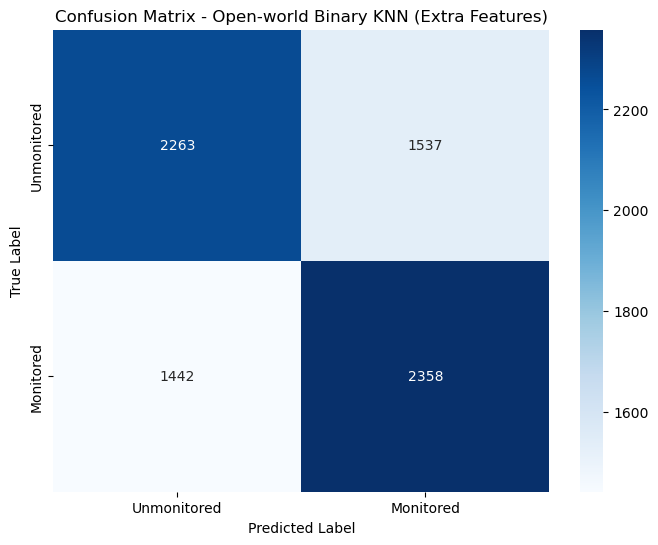

In [6]:
# Confusion Matrix 시각화
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Unmonitored', 'Monitored'],
            yticklabels=['Unmonitored', 'Monitored'])
plt.title('Confusion Matrix - Open-world Binary KNN (Extra Features)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
